### FINBERT

In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import nltk
from nltk.corpus import stopwords

model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


ModuleNotFoundError: No module named 'torch'

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

#### Speech Data

In [3]:
speech = pd.read_excel('../../Data/Final/speech_df.xlsx', index_col = 1)

In [4]:
speech

,Unnamed: 0,title,speaker,speech
date,,,,
"November 16, 2023",0,"Global Linkages: Supply, Spillovers, and Comm...",Governor Lisa D. Cook,"Thank you, Sylvain, and thank you for the opp..."
"November 16, 2023",1,The 2023 U.S. Treasury Market Conference,Vice Chair for Supervision Michael S. Barr,I am pleased to join you today at the ninth a...
"November 14, 2023",2,Elevated Economic Uncertainty: Causes and Cons...,Vice Chair Philip N. Jefferson,Introduction \nThank you for the opportunity ...
"November 13, 2023",3,Welcoming Remarks,Governor Lisa D. Cook,"Good morning, and welcome to the 5th annual c..."
"November 09, 2023",4,Opening Remarks,Chair Jerome H. Powell,Thank you for the opportunity to participate ...
...,...,...,...,...
"February 24, 2006",1041,The Benefits of Price Stability,Chairman Ben S. Bernanke,It is a great pleasure for me to return to Pr...
"February 23, 2006",1042,"Globalization, Insurers, and Regulators: Share...","Vice Chairman Roger W. Ferguson, Jr.",I am honored to deliver the keynote address a...
"February 06, 2006",1043,Remarks at ceremonial swearing-in by President...,Chairman Ben S. Bernanke,Good morning. I would like to begin by thanki...


In [5]:
speech.index = pd.to_datetime(speech.index)

In [6]:
speech

,Unnamed: 0,title,speaker,speech
date,,,,
2023-11-16,0,"Global Linkages: Supply, Spillovers, and Comm...",Governor Lisa D. Cook,"Thank you, Sylvain, and thank you for the opp..."
2023-11-16,1,The 2023 U.S. Treasury Market Conference,Vice Chair for Supervision Michael S. Barr,I am pleased to join you today at the ninth a...
2023-11-14,2,Elevated Economic Uncertainty: Causes and Cons...,Vice Chair Philip N. Jefferson,Introduction \nThank you for the opportunity ...
2023-11-13,3,Welcoming Remarks,Governor Lisa D. Cook,"Good morning, and welcome to the 5th annual c..."
2023-11-09,4,Opening Remarks,Chair Jerome H. Powell,Thank you for the opportunity to participate ...
...,...,...,...,...
2006-02-24,1041,The Benefits of Price Stability,Chairman Ben S. Bernanke,It is a great pleasure for me to return to Pr...
2006-02-23,1042,"Globalization, Insurers, and Regulators: Share...","Vice Chairman Roger W. Ferguson, Jr.",I am honored to deliver the keynote address a...
2006-02-06,1043,Remarks at ceremonial swearing-in by President...,Chairman Ben S. Bernanke,Good morning. I would like to begin by thanki...


In [8]:
daily_sentiments = pd.DataFrame(columns = ["Date", "Positive", "Negative", "Neutral"])
unique_dates = speech.index.unique()
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
text_for_date = speech["speech"].tolist()

tokenized_texts = [
        [word for word in tokenizer.tokenize(text) if word.lower() not in stop_words]
        for text in text_for_date]

In [11]:
len(tokenized_texts)

1046

In [12]:
len(tokenized_texts[0])

1917

In [ ]:
len(max(tokenized_texts, key = len))

In [ ]:
import time 
start_time = time.time()

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

for date in unique_dates:    
    #text_for_date = data[data["rgs_dt"] == date]["news_smy_ifo"].tolist()
    text_for_date = speech[speech.index == date]["speech"].tolist()

    tokenized_texts = [
        [word for word in tokenizer.tokenize(text) if word.lower() not in stop_words]
        for text in text_for_date
    ]

    max_token_length = 512

    tokenized_texts = [" ".join(tokens[:max_token_length]) for tokens in tokenized_texts]
    inputs = tokenizer(tokenized_texts, padding = True, truncation = True, return_tensors = "pt", max_length = max_token_length)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1)
    positive_prob = probabilities[:, 2].mean().item()
    negative_prob = probabilities[:, 0].mean().item()
    neutral_prob = probabilities[:, 1].mean().item()
    
    daily_sentiments = pd.concat([daily_sentiments, 
                                  pd.DataFrame({"Date": date, 
                                                "Positive": positive_prob, 
                                                "Negative": negative_prob, 
                                                "Neutral": neutral_prob}, index = ['0'])],
                                 ignore_index = True)

print(f'spent time : {time.time() - start_time}')
daily_sentiments.index = daily_sentiments.Date
daily_sentiments = daily_sentiments.iloc[:,1:]
daily_sentiments

In [ ]:
daily_sentiments['sentimental_score'] = daily_sentiments['Positive'] - daily_sentiments['Negative'] + daily_sentiments['Neutral'] * 0.5

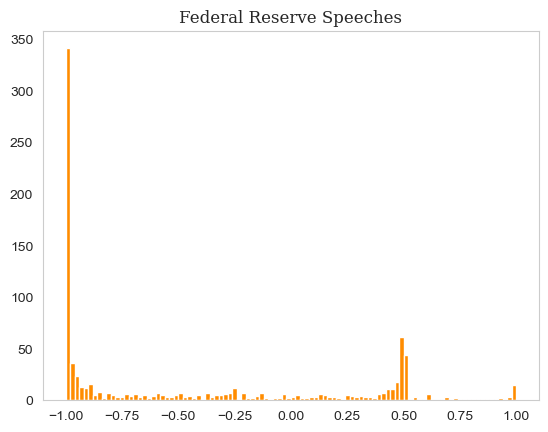

In [14]:
import matplotlib.pyplot as plt

plt.hist(daily_sentiments['sentimental_score'], bins = 100, color = 'darkorange')
plt.grid(False)
plt.title("Federal Reserve Speeches", fontsize = 12, fontfamily = 'Serif')
plt.show()

In [15]:
daily_sentiments.resample('M').mean()

,Positive,Negative,Neutral,sentimental_score
Date,,,,
2006-01-31,0.000009,0.000472,0.999519,0.499296
2006-02-28,0.000317,0.515556,0.484128,-0.273175
2006-03-31,0.000115,0.508240,0.491644,-0.262303
2006-04-30,0.000724,0.612916,0.386360,-0.419012
2006-05-31,0.001353,0.528266,0.470380,-0.291723
...,...,...,...,...
2023-07-31,0.000121,0.999553,0.000325,-0.999269
2023-08-31,0.000394,0.534201,0.465406,-0.301104
2023-09-30,0.000326,0.601556,0.398118,-0.402171


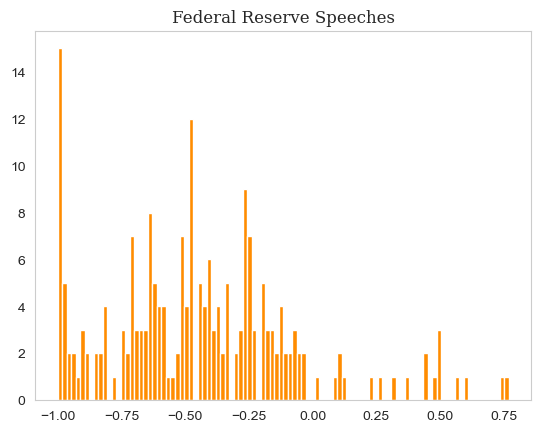

In [16]:
plt.hist(daily_sentiments.resample('M').mean()['sentimental_score'], bins = 100, color = 'darkorange')
plt.grid(False)
plt.title("Federal Reserve Speeches", fontsize = 12, fontfamily = 'Serif')
plt.show()

In [17]:
#daily_sentiments.resample('M').mean().to_csv('../../Data/federal_sentiment.csv')

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
import re

nltk.download('stopwords')
nltk.download('punkt')

documents = list(speech.speech)

stop_words = set(stopwords.words('english'))
processed_docs = [[word for word in word_tokenize(doc.lower()) if word not in stop_words and re.match('[a-zA-Z]+', word)] for doc in documents]

dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

lda_model = models.LdaModel(corpus, 
                            num_topics=4, 
                            id2word=dictionary, 
                            passes=5)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Topic: 0 
Words: 0.017*"inflation" + 0.010*"policy" + 0.010*"rate" + 0.009*"percent" + 0.007*"economy" + 0.006*"federal" + 0.006*"economic" + 0.006*"market" + 0.006*"growth" + 0.006*"monetary"
Topic: 1 
Words: 0.018*"financial" + 0.009*"banks" + 0.008*"capital" + 0.007*"market" + 0.007*"risk" + 0.006*"federal" + 0.006*"reserve" + 0.006*"system" + 0.005*"bank" + 0.005*"credit"
Topic: 2 
Words: 0.014*"policy" + 0.010*"financial" + 0.009*"federal" + 0.008*"inflation" + 0.008*"monetary" + 0.007*"bank" + 0.006*"reserve" + 0.006*"central" + 0.006*"economic" + 0.006*"rate"
Topic: 3 
Words: 0.008*"banks" + 0.008*"community" + 0.008*"financial" + 0.005*"also" + 0.005*"federal" + 0.005*"economic" + 0.005*"reserve" + 0.004*"credit" + 0.004*"bank" + 0.004*"percent"


In [28]:
lda_model.show_topic(1)

[('financial', 0.0177614),
 ('banks', 0.009374482),
 ('capital', 0.00794341),
 ('market', 0.007080088),
 ('risk', 0.0069455695),
 ('federal', 0.00626854),
 ('reserve', 0.0057302252),
 ('system', 0.0055617127),
 ('bank', 0.0054274923),
 ('credit', 0.0053125825)]

In [18]:
lda_model.get_document_topics(documents)

ValueError: too many values to unpack (expected 2)

#### Press_Data

In [18]:
press = pd.read_excel('../../Data/Final/press_df.xlsx', index_col = 1)

In [19]:
press.head()

,Unnamed: 0,title,speech
date,,,
"November 22, 2023",0,Agencies extend comment period on proposed ru...,Federal bank regulatory agencies announced to...
"November 21, 2023",1,Federal Reserve Board announces approval of ap...,The Federal Reserve Board on Tuesday announce...
"November 21, 2023",2,"Minutes of the Federal Open Market Committee, ...",The Federal Reserve on Tuesday released the m...
"November 21, 2023",3,Federal Reserve Board issues enforcement actio...,The Federal Reserve Board on Tuesday announce...
"November 17, 2023",4,Federal Reserve announces College Fed Challeng...,Harvard College won the 20th annual national ...


In [20]:
daily_sentiments = pd.DataFrame(columns = ["Date", "Positive", "Negative", "Neutral"])
unique_dates = press.index.unique()
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
text_for_date = press["speech"].tolist()

In [22]:
tokenized_texts = []
for text in text_for_date :
    try : 
        temp = []
        for word in tokenizer.tokenize(text) :
            if word.lower() not in stop_words :
                temp.append(word)
        tokenized_texts.append(temp)
    except : pass

In [23]:
import time
daily_sentiments_excerpt = pd.DataFrame(columns = ["Date", "Positive", "Negative", "Neutral"])
start_time = time.time()

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

for date in unique_dates:    
    #text_for_date = data[data["rgs_dt"] == date]["news_smy_ifo"].tolist()
    text_for_date = press[press.index == date]["speech"].tolist()

    tokenized_texts = []
    for text in text_for_date :
        try : 
            temp = []
            for word in tokenizer.tokenize(text) :
                if word.lower() not in stop_words :
                    temp.append(word)
            tokenized_texts.append(temp)
        except : 
            tokenized_texts.append([])

    max_token_length = 512

    tokenized_texts = [" ".join(tokens[:max_token_length]) for tokens in tokenized_texts]
    inputs = tokenizer(tokenized_texts, padding = True, truncation = True, return_tensors = "pt", max_length = max_token_length)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1)
    positive_prob = probabilities[:, 2].mean().item()
    negative_prob = probabilities[:, 0].mean().item()
    neutral_prob = probabilities[:, 1].mean().item()
    
    daily_sentiments_excerpt = pd.concat([daily_sentiments_excerpt, 
                                          pd.DataFrame({"Date": date, 
                                                        "Positive": positive_prob, 
                                                        "Negative": negative_prob, 
                                                        "Neutral": neutral_prob}, index = ['0'])],
                                 ignore_index = True)

daily_sentiments_excerpt.index = daily_sentiments_excerpt.Date
daily_sentiments_excerpt = daily_sentiments_excerpt.iloc[:,1:]
daily_sentiments_excerpt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Positive,Negative,Neutral
Date,,,
"November 22, 2023",5.422469e-05,0.998995,0.000950
"November 21, 2023",6.874374e-04,0.996567,0.002745
"November 17, 2023",1.240634e-06,0.999995,0.000003
"November 15, 2023",1.945501e-04,0.999486,0.000320
"November 13, 2023",4.631872e-05,0.999673,0.000281
...,...,...,...
"January 17, 2006",1.062821e-04,0.998626,0.001267
"January 13, 2006",4.509139e-05,0.999462,0.000493
"January 10, 2006",7.730573e-03,0.992146,0.000124


In [24]:
daily_sentiments_excerpt['sentimental_score'] = daily_sentiments_excerpt['Positive'] - daily_sentiments_excerpt['Negative'] + daily_sentiments_excerpt['Neutral'] * 0.5

In [25]:
daily_sentiments_excerpt.index = pd.to_datetime(daily_sentiments_excerpt.index)

In [26]:
daily_sentiments_excerpt = daily_sentiments_excerpt.iloc[:,1:]

In [27]:
daily_sentiments_excerpt = daily_sentiments_excerpt.resample('M').mean()

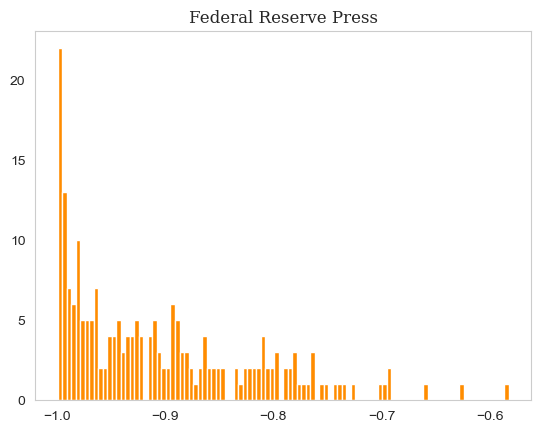

In [28]:
import matplotlib.pyplot as plt

plt.hist(daily_sentiments_excerpt['sentimental_score'], bins = 100, color = 'darkorange')
plt.grid(False)
plt.title("Federal Reserve Press", fontsize = 12, fontfamily = 'Serif')
plt.show()

In [29]:
# daily_sentiments_excerpt.to_csv('../../Data/Final/press_sentiment.csv')

#### Investing.com Data

In [35]:
invest = pd.read_csv('../../Data/Final/investing_crawling.csv')
invest

,Unnamed: 0,year,month,title
0,0,2023,11,US Black Friday sales rise 2.5% -Mastercard Sp...
1,1,2023,11,Poland's budget deficit hits PLN 36.42 billion...
2,2,2023,11,Bundesbank Chief Urges Swift Fiscal Planning f...
3,3,2023,11,Signa unit confirms bankruptcy filing in lette...
4,4,2023,11,Nigeria cenbank to tighten policy to curb infl...
...,...,...,...,...
22113,22113,2021,11,"Inflation, Rivian IPO, Jobless Claims - What's..."
22114,22114,2021,11,"German govt finances in critical state, federa..."
22115,22115,2021,11,Chinese state firms ask regulators to adjust l...
22116,22116,2021,11,Europe's pandemic productivity growth surge ma...


In [36]:
invest['index'] = invest['year'].astype(str) + '-' + invest['month'].astype(str)

In [37]:
invest.index = invest['index']

In [38]:
invest

,Unnamed: 0,year,month,title,index
index,,,,,
2023-11,0,2023,11,US Black Friday sales rise 2.5% -Mastercard Sp...,2023-11
2023-11,1,2023,11,Poland's budget deficit hits PLN 36.42 billion...,2023-11
2023-11,2,2023,11,Bundesbank Chief Urges Swift Fiscal Planning f...,2023-11
2023-11,3,2023,11,Signa unit confirms bankruptcy filing in lette...,2023-11
2023-11,4,2023,11,Nigeria cenbank to tighten policy to curb infl...,2023-11
...,...,...,...,...,...
2021-11,22113,2021,11,"Inflation, Rivian IPO, Jobless Claims - What's...",2021-11
2021-11,22114,2021,11,"German govt finances in critical state, federa...",2021-11
2021-11,22115,2021,11,Chinese state firms ask regulators to adjust l...,2021-11


In [39]:
unique_dates = invest.index.unique()
unique_dates

Index(['2023-11', '2023-10', '2023-9', '2023-8', '2023-7', '2023-6', '2023-5',
       '2023-4', '2023-3', '2023-2', '2023-1', '2022-12', '2022-11', '2022-10',
       '2022-9', '2022-8', '2022-7', '2022-6', '2022-5', '2022-4', '2022-3',
       '2022-2', '2022-1', '2021-12', '2021-11'],
      dtype='object', name='index')

In [40]:
import time
daily_sentiments_excerpt = pd.DataFrame(columns = ["Date", "Positive", "Negative", "Neutral"])

start_time = time.time()

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

for date in unique_dates:    
    #text_for_date = data[data["rgs_dt"] == date]["news_smy_ifo"].tolist()
    text_for_date = invest[invest.index == date]["title"].tolist()

    tokenized_texts = []
    for text in text_for_date :
        try : 
            temp = []
            for word in tokenizer.tokenize(text) :
                if word.lower() not in stop_words :
                    temp.append(word)
            tokenized_texts.append(temp)
        except : 
            tokenized_texts.append([])

    max_token_length = 500

    tokenized_texts = [" ".join(tokens[:max_token_length]) for tokens in tokenized_texts]
    inputs = tokenizer(tokenized_texts, padding = True, truncation = True, return_tensors = "pt", max_length = max_token_length)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1)
    positive_prob = probabilities[:, 2].mean().item()
    negative_prob = probabilities[:, 0].mean().item()
    neutral_prob = probabilities[:, 1].mean().item()
    
    daily_sentiments_excerpt = pd.concat([daily_sentiments_excerpt, 
                                          pd.DataFrame({"Date": date, 
                                                        "Positive": positive_prob, 
                                                        "Negative": negative_prob, 
                                                        "Neutral": neutral_prob}, index = ['0'])],
                                 ignore_index = True)

print(f'spent time : {time.time() - start_time}')
daily_sentiments_excerpt.index = daily_sentiments_excerpt.Date
daily_sentiments_excerpt = daily_sentiments_excerpt.iloc[:,1:]
daily_sentiments_excerpt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


spent time : 224.32314705848694


,Positive,Negative,Neutral
Date,,,
2023-11,0.159651,0.646914,0.193435
2023-10,0.160515,0.635881,0.203604
2023-9,0.151963,0.656168,0.191869
2023-8,0.122717,0.711143,0.166141
2023-7,0.103711,0.745990,0.150299
2023-6,0.094562,0.734463,0.170975
2023-5,0.138747,0.724805,0.136448
2023-4,0.130142,0.714174,0.155683
2023-3,0.131547,0.734119,0.134333


In [41]:
daily_sentiments_excerpt['sentimental_score'] = daily_sentiments_excerpt['Positive'] - daily_sentiments_excerpt['Negative'] + daily_sentiments_excerpt['Neutral'] * 0.5

In [42]:
daily_sentiments_excerpt.index = pd.to_datetime(daily_sentiments_excerpt.index)

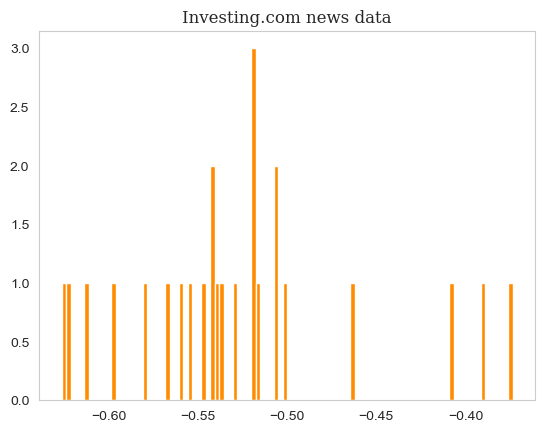

In [43]:
import matplotlib.pyplot as plt

plt.hist(daily_sentiments_excerpt['sentimental_score'], bins = 100, color = 'darkorange')
plt.grid(False)
plt.title("Investing.com news data", fontsize = 12, fontfamily = 'Serif')
plt.show()

In [44]:
# daily_sentiments_excerpt.to_csv('../../Data/Final/invest_com_sentiment.csv')

#### FT Titles

In [45]:
ft = pd.read_csv('../../Data/Final/ft_crawling.csv')
ft

,Unnamed: 0,year,month,title
0,0,2023,11,Investors pour cash into US corporate debt in ...
1,1,2023,11,Fed officials showed little urgency to raise r...
2,2,2023,11,Emerging market central banks may be trumping ...
3,3,2023,11,The Fed’s balance sheet isn’t so boring after all
4,4,2023,11,Falling fuel prices and airfares bring relief ...
...,...,...,...,...
2944,2944,2018,12,Fed’s Powell poised to set rates policy tone f...
2945,2945,2018,12,"Week ahead: Fed, BoE, US government shutdown"
2946,2946,2018,12,Investors signal concerns with leveraged loans
2947,2947,2018,12,An error-correcting inflation target


In [46]:
ft.index = ft['year'].astype(str) + '-' + ft['month'].astype(str)

In [47]:
unique_dates = ft.index.unique()
unique_dates

Index(['2023-11', '2023-10', '2023-9', '2023-8', '2023-7', '2023-6', '2023-5',
       '2023-4', '2023-3', '2023-2', '2023-1', '2022-12', '2022-11', '2022-10',
       '2022-9', '2022-8', '2022-7', '2022-6', '2022-5', '2022-4', '2022-3',
       '2022-2', '2022-1', '2021-12', '2021-11', '2021-10', '2021-9', '2021-8',
       '2021-7', '2021-6', '2021-5', '2021-4', '2021-3', '2021-2', '2021-1',
       '2020-12', '2020-11', '2020-10', '2020-9', '2020-8', '2020-7', '2020-6',
       '2020-5', '2020-4', '2020-3', '2020-2', '2020-1', '2019-12', '2019-11',
       '2019-10', '2019-9', '2019-8', '2019-7', '2019-6', '2019-5', '2019-4',
       '2019-3', '2019-2', '2019-1', '2018-12'],
      dtype='object')

In [48]:
import time
daily_sentiments_excerpt = pd.DataFrame(columns = ["Date", "Positive", "Negative", "Neutral"])

start_time = time.time()

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

for date in unique_dates:    
    #text_for_date = data[data["rgs_dt"] == date]["news_smy_ifo"].tolist()
    text_for_date = ft[ft.index == date]["title"].tolist()

    tokenized_texts = []
    for text in text_for_date :
        try : 
            temp = []
            for word in tokenizer.tokenize(text) :
                if word.lower() not in stop_words :
                    temp.append(word)
            tokenized_texts.append(temp)
        except : 
            tokenized_texts.append([])

    max_token_length = 500

    tokenized_texts = [" ".join(tokens[:max_token_length]) for tokens in tokenized_texts]
    inputs = tokenizer(tokenized_texts, padding = True, truncation = True, return_tensors = "pt", max_length = max_token_length)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1)
    positive_prob = probabilities[:, 2].mean().item()
    negative_prob = probabilities[:, 0].mean().item()
    neutral_prob = probabilities[:, 1].mean().item()
    
    daily_sentiments_excerpt = pd.concat([daily_sentiments_excerpt, 
                                          pd.DataFrame({"Date": date, 
                                                        "Positive": positive_prob, 
                                                        "Negative": negative_prob, 
                                                        "Neutral": neutral_prob}, index = ['0'])],
                                 ignore_index = True)

print(f'spent time : {time.time() - start_time}')
daily_sentiments_excerpt.index = daily_sentiments_excerpt.Date
daily_sentiments_excerpt = daily_sentiments_excerpt.iloc[:,1:]
daily_sentiments_excerpt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


spent time : 23.534430027008057


,Positive,Negative,Neutral
Date,,,
2023-11,0.174408,0.688674,0.136918
2023-10,0.241055,0.525816,0.233129
2023-9,0.224177,0.573975,0.201848
2023-8,0.144376,0.757819,0.097805
2023-7,0.298952,0.569860,0.131188
2023-6,0.085023,0.727201,0.187776
2023-5,0.242027,0.627649,0.130324
2023-4,0.289253,0.593404,0.117343
2023-3,0.262735,0.627765,0.109500


In [49]:
daily_sentiments_excerpt['sentimental_score'] = daily_sentiments_excerpt['Positive'] - daily_sentiments_excerpt['Negative'] + daily_sentiments_excerpt['Neutral'] * 0.5
daily_sentiments_excerpt.index = pd.to_datetime(daily_sentiments_excerpt.index)

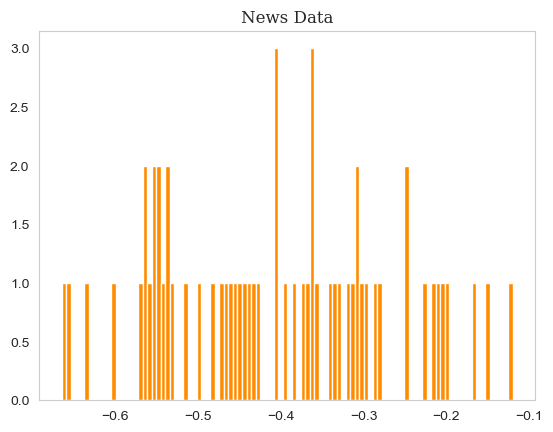

In [50]:
plt.hist(daily_sentiments_excerpt['sentimental_score'], bins = 100, color = 'darkorange')
plt.grid(False)
plt.title("News Data", fontsize = 12, fontfamily = 'Serif')
plt.show()

In [51]:
# daily_sentiments_excerpt.to_csv('../../Data/Final/ft_sentiment.csv')

#### USDT article

In [3]:
usdt = pd.read_csv('../../Data/Final/USDT_article_total.csv')
usdt.date = pd.to_datetime(usdt.date)
usdt.index = usdt.date
usdt.sort_index(ascending=True, inplace = True)

In [4]:
usdt = usdt.iloc[:-1]
usdt

,title,date,content
date,,,
2008-01-07,Remarks by Treasury Secretary Henry M. Paulson...,2008-01-07,"As I have said for some time, the housing ..."
2008-01-14,Remarks by Treasury Under Secretary David H. M...,2008-01-14,"La Jolla, Calif. - Thank you Phil for that..."
2008-01-22,Secretary Paulson Remarks on the Economy Befor...,2008-01-22,"Washington- Thank you, Bruce, and good m..."
2008-01-24,Under Secretary David H. McCormick to Deliver ...,2008-01-24,Treasury Under Secretary David H. McCormick ...
2008-01-28,Treasury Assistant Secretary for Financial Mar...,2008-01-28,"In assessing liquidity, we must begin by r..."
...,...,...,...
2023-11-13,Remarks by Secretary of the Treasury Janet L. ...,2023-11-13,As Prepared for Delivery Thank you to Lieuten...
2023-11-15,Remarks By Secretary of the Treasury Janet L. ...,2023-11-15,As Prepared for Delivery Hello everyone. I’m ...
2023-11-16,Remarks by Under Secretary for Domestic Financ...,2023-11-16,As Prepared for Delivery Good morning and tha...


In [5]:
daily_sentiments = pd.DataFrame(columns = ["Date", "Positive", "Negative", "Neutral"])
unique_dates = usdt.index.unique()
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
unique_dates = usdt.index.unique()
unique_dates

DatetimeIndex(['2008-01-07', '2008-01-14', '2008-01-22', '2008-01-24',
               '2008-01-28', '2008-01-29', '2008-01-30', '2008-02-05',
               '2008-02-07', '2008-02-08',
               ...
               '2023-11-03', '2023-11-07', '2023-11-09', '2023-11-10',
               '2023-11-12', '2023-11-13', '2023-11-15', '2023-11-16',
               '2023-11-17', '2023-11-21'],
              dtype='datetime64[ns]', name='date', length=765, freq=None)

In [8]:
import time
daily_sentiments_excerpt = pd.DataFrame(columns = ["Date", "Positive", "Negative", "Neutral"])

start_time = time.time()

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

for date in unique_dates:    
    #text_for_date = data[data["rgs_dt"] == date]["news_smy_ifo"].tolist()
    text_for_date = usdt[usdt.index == date]["content"].tolist()

    tokenized_texts = []
    for text in text_for_date :
        try : 
            temp = []
            for word in tokenizer.tokenize(text) :
                if word.lower() not in stop_words :
                    temp.append(word)
            tokenized_texts.append(temp)
        except : 
            tokenized_texts.append([])

    max_token_length = 500

    tokenized_texts = [" ".join(tokens[:max_token_length]) for tokens in tokenized_texts]
    inputs = tokenizer(tokenized_texts, padding = True, truncation = True, return_tensors = "pt", max_length = max_token_length)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1)
    positive_prob = probabilities[:, 2].mean().item()
    negative_prob = probabilities[:, 0].mean().item()
    neutral_prob = probabilities[:, 1].mean().item()
    
    daily_sentiments_excerpt = pd.concat([daily_sentiments_excerpt, 
                                          pd.DataFrame({"Date": date, 
                                                        "Positive": positive_prob, 
                                                        "Negative": negative_prob, 
                                                        "Neutral": neutral_prob}, index = ['0'])],
                                 ignore_index = True)

print(f'spent time : {time.time() - start_time}')
daily_sentiments_excerpt.index = daily_sentiments_excerpt.Date
daily_sentiments_excerpt = daily_sentiments_excerpt.iloc[:,1:]
daily_sentiments_excerpt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


spent time : 176.55477714538574


,Positive,Negative,Neutral
Date,,,
2008-01-07,1.564376e-03,0.783840,0.214596
2008-01-14,1.094061e-04,0.993025,0.006866
2008-01-22,9.106998e-07,0.000029,0.999970
2008-01-24,1.283392e-05,0.999986,0.000001
2008-01-28,6.957560e-05,0.890780,0.109150
...,...,...,...
2023-11-13,2.368747e-06,0.001262,0.998736
2023-11-15,1.569805e-04,0.772632,0.227211
2023-11-16,3.782207e-03,0.820299,0.175919


In [9]:
daily_sentiments_excerpt['sentimental_score'] = daily_sentiments_excerpt['Positive'] - daily_sentiments_excerpt['Negative'] + daily_sentiments_excerpt['Neutral'] * 0.5

In [11]:
temp = daily_sentiments_excerpt.resample('M').mean()

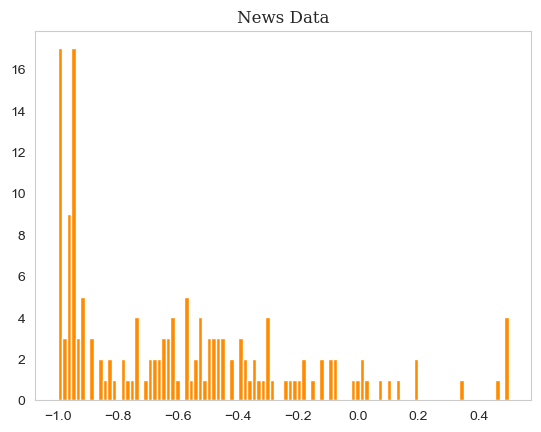

In [13]:
import matplotlib.pyplot as plt

plt.hist(temp['sentimental_score'], bins = 100, color = 'darkorange')
plt.grid(False)
plt.title("News Data", fontsize = 12, fontfamily = 'Serif')
plt.show()

In [66]:
#daily_sentiments_excerpt.resample('M').mean().to_csv('../../Data/Final/USDT_sentiment.csv')